## Astronauts. ATOM, OSMO and LUNA Analysis

In [1]:
import pandas as pd
import numpy as np
from math import log10

from src.extractor_cosmos_sdk_snapshots import get_balances
from src.utils_bigquery import create_table_from_df, drop_table
from src.utils_charts import grade_boundaries_analysis
from config import ASTRONAUTS_DATASET_NAME, ASTRONAUTS_DISTRIBUTION_TABLE_NAME, COSMOS_SEGMENT, OSMOSIS_SEGMENT, TERRA_SEGMENT

DROP_TABLES = True
CREATE_TABLES = True

In [2]:
atom_owners_initial_boundary = 1
luna_owners_initial_boundary = 1
osmo_owners_initial_boundary = 1

### Get Snapshots
#### Cosmos
You can get snapshot from Cosmos Hub by the command:

```bash
gaiad export --for-zero-height --height <height block> > cosmos_snapshot.json
```

The snapshot that was used is [here](https://ipfs.io/ipfs/QmeJ5yK6nBeGv3zNpbQss1Ke1fFAdGmWypT17VYPoEj55R) at the 8,241,100 block.

#### Osmosis

You can get snapshot from Osmosis node by the command:

```bash
osmosisd export --height <height block>  >> osmosis_snapshot.json
```

The snapshot that was used is [here](https://ipfs.io/ipfs/QmZYMyMzjCGAvPd3JGEywhHiYMQDexy8cza7jGyQQ1i1pL) at the 1,873,000 block.


#### Terra

You can get snapshot from Terra node by the command:

```bash
terrad export --height <height block> >> terra_snapshot.json
```

The snapshot that was used is [here](https://ipfs.io/ipfs/QmZZxo9zghunv627gW9rMtijc1nn3NTLri83cFXsvm4Jqy) at the 5,178,000 block.

### Analysis of Grade Boundaries. Atom Owners

Suggestion of Rules: 



Grade,Rule,Addresses,Percentage of Addresses
1,1 < ATOM Balance <= 180.0,175496,88.9
2,180.0 < ATOM Balance <= 4352.0,19832,10.1
3,4352.0 < ATOM Balance,1973,1.0


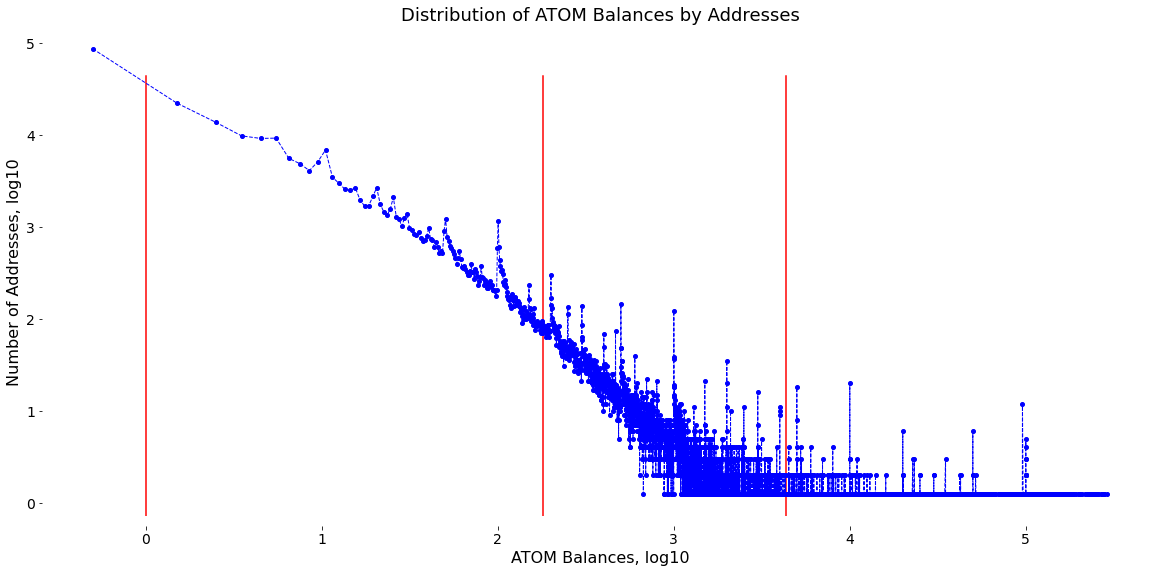

In [3]:
atom_balances_df = get_balances(snapshot_url="data/cosmos_snapshot.json", coin='uatom')
atom_balances_agg_df = \
    atom_balances_df.groupby('balance_coin_rounded')['address'].agg([('number_of_addresses', np.count_nonzero)]).reset_index()

atom_owners_boundary =\
    grade_boundaries_analysis(
        distribution_df=atom_balances_agg_df,
        value_column='balance_coin_rounded',
        address_column='number_of_addresses',
        address_chart_label='Number of Addresses, log10',
        value_chart_label='ATOM Balance, log10',
        value_name='ATOM Balance',
        value_transform_func=lambda x: log10(x) if x >= 0.1 else -1.8,
        chart_title='Distribution of ATOM Balances by Addresses',
        max_show_value=300000,
        initial_boundary=atom_owners_initial_boundary,
        level_line_shift=0,
        boundary_round=0)

### Analysis of Grade Boundaries. Luna Owners

Suggestion of Rules: 



Grade,Rule,Addresses,Percentage of Addresses
1,1 < LUNA Balance <= 568.0,97803,89.0
2,568.0 < LUNA Balance <= 12364.0,11005,10.0
3,12364.0 < LUNA Balance,1100,1.0


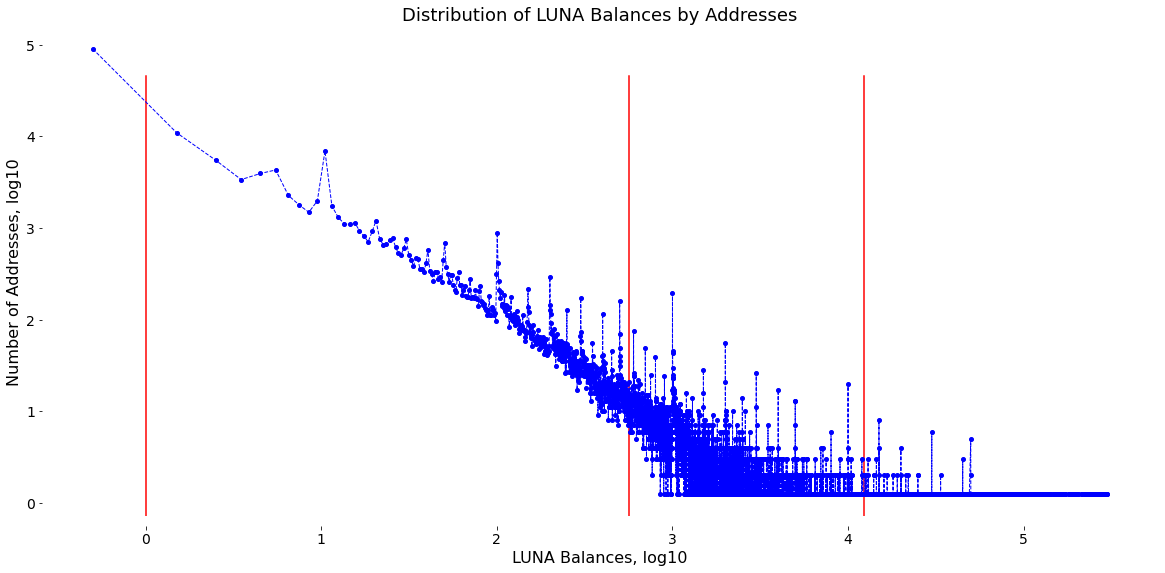

In [4]:
luna_balances_df = get_balances(snapshot_url="data/terra_snapshot.json", coin='uluna')
luna_balances_agg_df = \
   luna_balances_df.groupby('balance_coin_rounded')['address'].agg([('number_of_addresses', np.count_nonzero)]).reset_index()

luna_owners_boundary =\
    grade_boundaries_analysis(
        distribution_df=luna_balances_agg_df,
        value_column='balance_coin_rounded',
        address_column='number_of_addresses',
        address_chart_label='Number of Addresses, log10',
        value_chart_label='LUNA Balance, log10',
        value_name='LUNA Balance',
        value_transform_func=lambda x: log10(x) if x >= 0.1 else -1.8,
        chart_title='Distribution of LUNA Balances by Addresses',
        max_show_value=300000,
        initial_boundary=luna_owners_initial_boundary,
        level_line_shift=0,
        boundary_round=0)

### Analysis of Grade Boundaries. Osmo Owners and Liquidity Providers

Suggestion of Rules: 



Grade,Rule,Addresses,Percentage of Addresses
1,1 < OSMO Balance and Liquidity <= 752.0,93362,89.0
2,752.0 < OSMO Balance and Liquidity <= 24352.0,10489,10.0
3,24352.0 < OSMO Balance and Liquidity,1050,1.0


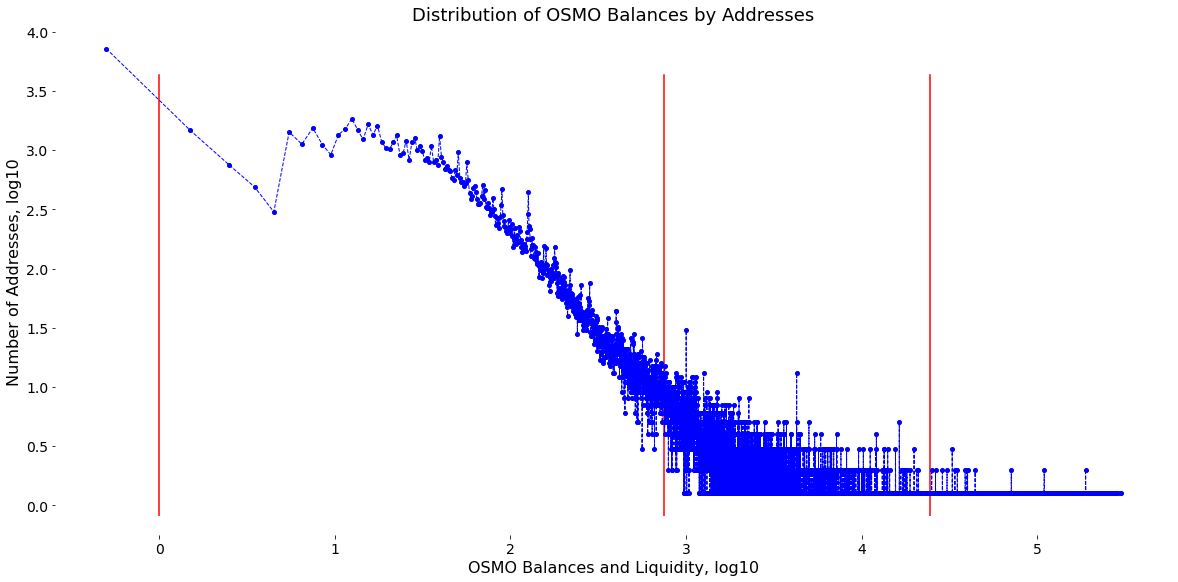

In [5]:
osmo_balances_df = get_balances(snapshot_url="data/osmosis_snapshot.json", coin='uosmo')
osmo_balances_agg_df = \
    osmo_balances_df.groupby('balance_coin_rounded')['address'].agg([('number_of_addresses', np.count_nonzero)]).reset_index()

osmo_owners_boundary =\
    grade_boundaries_analysis(
        distribution_df=osmo_balances_agg_df,
        value_column='balance_coin_rounded',
        address_column='number_of_addresses',
        address_chart_label='Number of Addresses, log10',
        value_chart_label='OSMO Balance and Liquidity, log10',
        value_name='OSMO Balance and Liquidity',
        value_transform_func=lambda x: log10(x) if x >= 0.1 else -1.8,
        chart_title='Distribution of OSMO Balances by Addresses',
        max_show_value=300000,
        initial_boundary=atom_owners_initial_boundary,
        level_line_shift=0,
        boundary_round=0)

### Distribution Rules

<table style="text-align: center">
    <thead>
        <tr>
            <th rowspan=2> </th>
            <th colspan=3>Grade</th>
        </tr>
        <tr>
            <th>1</th>
            <th>2</th>
            <th>3</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"> ATOM Balance </td>
            <td> > 1 ATOM </td>
            <td> > 180 ATOM </td>
            <td> > 4,352 ATOM </td>
        </tr>
        <tr>
            <td style="text-align: left"> OSMO Balance and Liquidity </td>
            <td> > 1 OSMO </td>
            <td> > 752 OSMO </td>
            <td> > 24,352 OSMO </td>
        </tr>
        <tr>
            <td style="text-align: left"> LUNA Balance </td>
            <td> > 1 LUNA </td>
            <td> > 568 LUNA </td>
            <td> > 12,364 LUNA </td>
        </tr>
    </tbody>
</table>

### Create Distribution Table

In [6]:
def set_grade(x: float, owners_boundary: list):
    if x > owners_boundary[2]:
        return 3
    elif x > owners_boundary[1]:
        return 2
    elif x > owners_boundary[0]:
        return 1
    return None

atom_balances_df.loc[:,'grade'] = atom_balances_df['balance_coin'].map(lambda x: set_grade(x, owners_boundary=atom_owners_boundary))
atom_balances_df.loc[:,'segment'] = COSMOS_SEGMENT
osmo_balances_df.loc[:,'grade'] = osmo_balances_df['balance_coin'].map(lambda x: set_grade(x, owners_boundary=osmo_owners_boundary))
osmo_balances_df.loc[:,'segment'] = OSMOSIS_SEGMENT
luna_balances_df.loc[:,'grade'] = luna_balances_df['balance_coin'].map(lambda x: set_grade(x, owners_boundary=luna_owners_boundary))
luna_balances_df.loc[:,'segment'] = TERRA_SEGMENT

balances_df = pd.concat([atom_balances_df, osmo_balances_df, luna_balances_df])

In [7]:
if CREATE_TABLES:
    create_table_from_df(source_df=balances_df[['address', 'segment', 'grade', 'balance_coin']],
                         table_name=ASTRONAUTS_DISTRIBUTION_TABLE_NAME,
                         dataset_name=ASTRONAUTS_DATASET_NAME,
                         drop_existing_table=DROP_TABLES)
elif DROP_TABLES:
    drop_table(table_name=ASTRONAUTS_DISTRIBUTION_TABLE_NAME,
               dataset_name=ASTRONAUTS_DATASET_NAME)

404 DELETE https://bigquery.googleapis.com/bigquery/v2/projects/cosmic-keep-223223/datasets/astronauts/tables/astronauts_distribution?prettyPrint=false: Not found: Table cosmic-keep-223223:astronauts.astronauts_distribution
Table astronauts:astronauts_distribution has not been deleted.
Table astronauts:astronauts_distribution has been created.
